#Google Drive Authentication

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importing Libraries

In [ ]:
import re
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow import keras
from bs4 import BeautifulSoup 

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings("ignore")

#Converting XML to csv

In [ ]:
file = open("drive/MyDrive/train.xml",'r')
contents = file.read()

In [ ]:
doc = BeautifulSoup(contents,'xml')

In [ ]:
text_ = doc.find_all('text')
aspectCategories = doc.find_all('aspectCategories')

In [ ]:
text_list = []
categ_list=[]
polarity_list=[]
for i in range(len(text_)):
   t= text_[i].get_text()
   acs=aspectCategories[i].find_all('aspectCategory')
   for j in range(len(acs)):
     categ= acs[j]['category']
     prior= acs[j]['polarity']
     text_list.append(t)
     categ_list.append(categ)
     polarity_list.append(prior)
df = pd.DataFrame(list(zip(text_list, categ_list,polarity_list)),
               columns =['text', 'aspect_category','polarity'])


In [ ]:
df.to_csv('train.csv',index=False)

In [ ]:
df.head()

,text,aspect_category,polarity
0,It might be the best sit down food I've had in...,food,positive
1,It might be the best sit down food I've had in...,place,neutral
2,Hostess was extremely accommodating when we ar...,staff,positive
3,Hostess was extremely accommodating when we ar...,miscellaneous,neutral
4,We were a couple of minutes late for our reser...,miscellaneous,neutral


#Aspects

In [ ]:
aspects = ["food", "staff", "miscellaneous", "place","service","menu","ambience","price"]

In [ ]:
df.aspect_category.value_counts()

food             2297
staff            1379
miscellaneous     947
place             693
service           630
menu              469
ambience          322
price             319
Name: aspect_category, dtype: int64

#Aspect Count Distribution

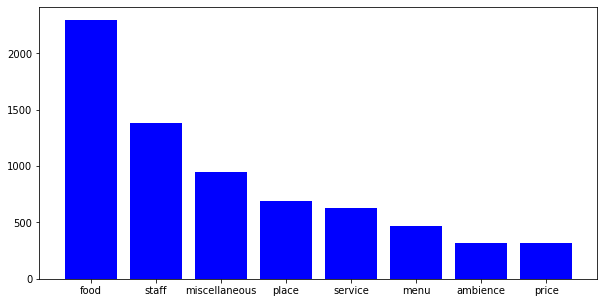

In [ ]:
data = {'food': 2297, 'staff': 1379,"miscellaneous":947,"place":693,"service":630,"menu":469,"ambience":322,"price":319}
names = list(data.keys())
values = list(data.values())
fig = plt.figure(figsize = (10, 5))
plt.bar(range(len(data)), values, tick_label=names,color="blue")
plt.show()

#LSTM model

In [ ]:
def model_lstm(length):
  model = Sequential()
  model.add(Embedding(5000, 256, input_length=length))
  model.add(Dropout(0.3))
  model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
  model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
  model.add(Dense(3, activation='softmax'))
  return model

#Preprocessing and Tokenizing

In [ ]:
def tokenizing(data,maxlen,flag):
  #preprocessing
  data['text'].apply(lambda x: x.lower()) #transform text to lowercase
  data['text'] = data['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))

  tokenizer = Tokenizer(num_words=5000, split=" ")
  tokenizer.fit_on_texts(data['text'].values)

  X = tokenizer.texts_to_sequences(data['text'].values)
  if flag=="testing":
    X=pad_sequences(X,maxlen=maxlen)
  else:
    X = pad_sequences(X) # padding our text vector so they all have the same length
  return X

#Training 

In [ ]:
def training(): 
  batch_size = 32
  epochs = 5

  tokenizing_length={}
  df_train=pd.read_csv("train.csv")

  for aspect in aspects:
          print(f"Starting {aspect}...")
          
          df_aspect = df_train[df_train.aspect_category ==aspect]
          df_aspect = df_aspect.drop(['aspect_category'], axis = 1)

          X = tokenizing(df_aspect,None,"training")
          maxlen = X.shape[1]
          tokenizing_length[aspect] = maxlen
          #print(maxlen)

          model = model_lstm(maxlen)
          model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

          y = pd.get_dummies(df_aspect['polarity']).values
      

          X_train, X_valid, y_train, y_valid =train_test_split(X, y, test_size=0.2, random_state=0)
          history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2,
                               validation_data=(X_valid,y_valid))
           
          print(history.history.keys())

          file_name = aspect+'.h5'
          path = '/content/drive/MyDrive/NLU_lstm_/'+file_name
          model.save(path)

          
          print("\n\naccuracy is : ")
          score = model.evaluate(X_valid, y_valid)
          print('Validation loss:', score[0]) 
          print('validation accuracy:', score[1])

          # Visualization 
          
          # summarize history for accuracy

          plt.subplot(211)
          plt.plot(history.history['accuracy'])
          plt.plot(history.history['val_accuracy'])
          plt.title('Model Accuracy')
          plt.ylabel('Accuracy')
          plt.xlabel('Epoch')
          plt.legend(['Training', 'Validation'], loc='lower right')

          # summarize history for loss

          plt.subplot(212)
          plt.plot(history.history['loss'])
          plt.plot(history.history['val_loss'])
          plt.title('Model Loss')
          plt.ylabel('Loss')
          plt.xlabel('Epoch')
          plt.legend(['Training', 'Validation'], loc='upper right')
          plt.tight_layout()

          plt.show()
  return tokenizing_length

Starting food...
Epoch 1/5
58/58 - 73s - loss: 0.9101 - accuracy: 0.6026 - val_loss: 0.7711 - val_accuracy: 0.6739 - 73s/epoch - 1s/step
Epoch 2/5
58/58 - 63s - loss: 0.6844 - accuracy: 0.7387 - val_loss: 0.7594 - val_accuracy: 0.7065 - 63s/epoch - 1s/step
Epoch 3/5
58/58 - 62s - loss: 0.4537 - accuracy: 0.8318 - val_loss: 0.8756 - val_accuracy: 0.6891 - 62s/epoch - 1s/step
Epoch 4/5
58/58 - 63s - loss: 0.2864 - accuracy: 0.9047 - val_loss: 0.9412 - val_accuracy: 0.6522 - 63s/epoch - 1s/step
Epoch 5/5
58/58 - 62s - loss: 0.1711 - accuracy: 0.9396 - val_loss: 1.0432 - val_accuracy: 0.6696 - 62s/epoch - 1s/step
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


accuracy is : 
15/15 [==============================] - 2s 160ms/step - loss: 1.0432 - accuracy: 0.6696
Validation loss: 1.043151617050171
validation accuracy: 0.6695652008056641


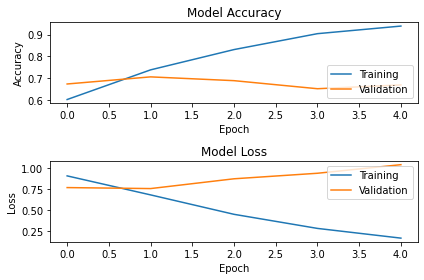

Starting staff...
Epoch 1/5
35/35 - 44s - loss: 0.8558 - accuracy: 0.6519 - val_loss: 0.8042 - val_accuracy: 0.6884 - 44s/epoch - 1s/step
Epoch 2/5
35/35 - 38s - loss: 0.7172 - accuracy: 0.7008 - val_loss: 0.7307 - val_accuracy: 0.7246 - 38s/epoch - 1s/step
Epoch 3/5
35/35 - 38s - loss: 0.5031 - accuracy: 0.7996 - val_loss: 0.7183 - val_accuracy: 0.7391 - 38s/epoch - 1s/step
Epoch 4/5
35/35 - 37s - loss: 0.2906 - accuracy: 0.8939 - val_loss: 2.1474 - val_accuracy: 0.5761 - 37s/epoch - 1s/step
Epoch 5/5
35/35 - 37s - loss: 0.1860 - accuracy: 0.9302 - val_loss: 0.9483 - val_accuracy: 0.6920 - 37s/epoch - 1s/step
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


accuracy is : 
9/9 [==============================] - 1s 164ms/step - loss: 0.9483 - accuracy: 0.6920
Validation loss: 0.9483482241630554
validation accuracy: 0.6920289993286133


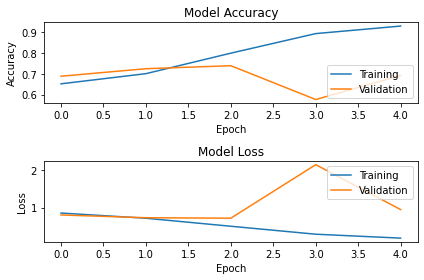

Starting miscellaneous...
Epoch 1/5
24/24 - 29s - loss: 1.0136 - accuracy: 0.5469 - val_loss: 0.9536 - val_accuracy: 0.5526 - 29s/epoch - 1s/step
Epoch 2/5
24/24 - 22s - loss: 0.8846 - accuracy: 0.6090 - val_loss: 0.9255 - val_accuracy: 0.5632 - 22s/epoch - 937ms/step
Epoch 3/5
24/24 - 22s - loss: 0.6530 - accuracy: 0.7279 - val_loss: 1.0317 - val_accuracy: 0.5737 - 22s/epoch - 925ms/step
Epoch 4/5
24/24 - 22s - loss: 0.3936 - accuracy: 0.8388 - val_loss: 1.1203 - val_accuracy: 0.5789 - 22s/epoch - 931ms/step
Epoch 5/5
24/24 - 22s - loss: 0.1735 - accuracy: 0.9458 - val_loss: 1.3202 - val_accuracy: 0.5842 - 22s/epoch - 927ms/step
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


accuracy is : 
6/6 [==============================] - 1s 135ms/step - loss: 1.3202 - accuracy: 0.5842
Validation loss: 1.3202229738235474
validation accuracy: 0.5842105150222778


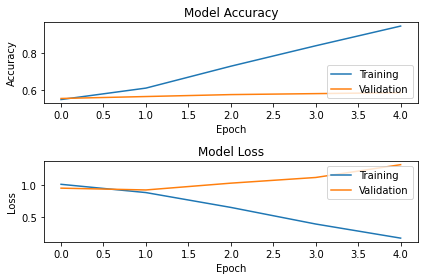

Starting place...
Epoch 1/5
18/18 - 23s - loss: 0.9862 - accuracy: 0.5939 - val_loss: 0.8417 - val_accuracy: 0.6619 - 23s/epoch - 1s/step
Epoch 2/5
18/18 - 17s - loss: 0.8506 - accuracy: 0.6173 - val_loss: 0.7683 - val_accuracy: 0.6691 - 17s/epoch - 935ms/step
Epoch 3/5
18/18 - 18s - loss: 0.6344 - accuracy: 0.7238 - val_loss: 0.7514 - val_accuracy: 0.6835 - 18s/epoch - 980ms/step
Epoch 4/5
18/18 - 17s - loss: 0.4869 - accuracy: 0.7960 - val_loss: 0.7961 - val_accuracy: 0.6691 - 17s/epoch - 930ms/step
Epoch 5/5
18/18 - 17s - loss: 0.2614 - accuracy: 0.9134 - val_loss: 1.0539 - val_accuracy: 0.6978 - 17s/epoch - 921ms/step
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


accuracy is : 
5/5 [==============================] - 1s 147ms/step - loss: 1.0539 - accuracy: 0.6978
Validation loss: 1.0539487600326538
validation accuracy: 0.6978417038917542


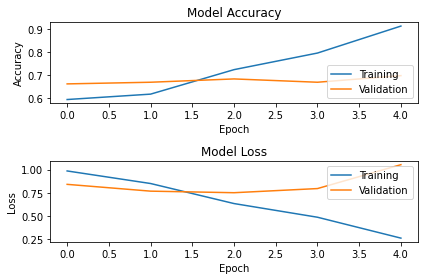

Starting service...
Epoch 1/5
16/16 - 22s - loss: 1.0473 - accuracy: 0.5020 - val_loss: 0.9808 - val_accuracy: 0.5476 - 22s/epoch - 1s/step
Epoch 2/5
16/16 - 16s - loss: 0.9824 - accuracy: 0.5139 - val_loss: 0.9921 - val_accuracy: 0.5159 - 16s/epoch - 1s/step
Epoch 3/5
16/16 - 16s - loss: 0.7578 - accuracy: 0.6429 - val_loss: 1.0319 - val_accuracy: 0.4762 - 16s/epoch - 998ms/step
Epoch 4/5
16/16 - 16s - loss: 0.5788 - accuracy: 0.7798 - val_loss: 1.1399 - val_accuracy: 0.5556 - 16s/epoch - 1s/step
Epoch 5/5
16/16 - 16s - loss: 0.4661 - accuracy: 0.8115 - val_loss: 1.3302 - val_accuracy: 0.5397 - 16s/epoch - 999ms/step
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


accuracy is : 
4/4 [==============================] - 1s 143ms/step - loss: 1.3302 - accuracy: 0.5397
Validation loss: 1.3301818370819092
validation accuracy: 0.5396825671195984


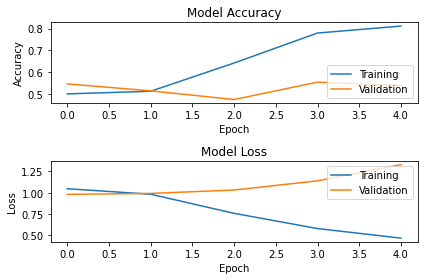

Starting menu...
Epoch 1/5
12/12 - 18s - loss: 0.8380 - accuracy: 0.7387 - val_loss: 0.6133 - val_accuracy: 0.8191 - 18s/epoch - 2s/step
Epoch 2/5
12/12 - 12s - loss: 0.6733 - accuracy: 0.7733 - val_loss: 0.5935 - val_accuracy: 0.8191 - 12s/epoch - 1s/step
Epoch 3/5
12/12 - 16s - loss: 0.5792 - accuracy: 0.7813 - val_loss: 0.5648 - val_accuracy: 0.7979 - 16s/epoch - 1s/step
Epoch 4/5
12/12 - 19s - loss: 0.3594 - accuracy: 0.8400 - val_loss: 0.7281 - val_accuracy: 0.7553 - 19s/epoch - 2s/step
Epoch 5/5
12/12 - 17s - loss: 0.3512 - accuracy: 0.8693 - val_loss: 0.6927 - val_accuracy: 0.7660 - 17s/epoch - 1s/step
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


accuracy is : 
3/3 [==============================] - 1s 163ms/step - loss: 0.6927 - accuracy: 0.7660
Validation loss: 0.6927300095558167
validation accuracy: 0.7659574747085571


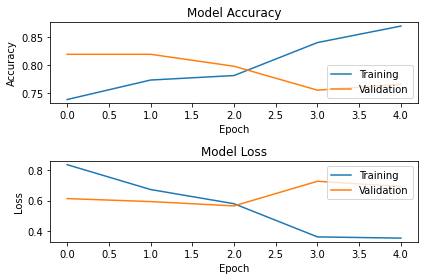

Starting ambience...
Epoch 1/5
9/9 - 14s - loss: 1.0871 - accuracy: 0.5486 - val_loss: 1.0501 - val_accuracy: 0.4923 - 14s/epoch - 2s/step
Epoch 2/5
9/9 - 8s - loss: 0.9796 - accuracy: 0.5798 - val_loss: 1.0387 - val_accuracy: 0.4923 - 8s/epoch - 850ms/step
Epoch 3/5
9/9 - 8s - loss: 0.9339 - accuracy: 0.5798 - val_loss: 1.0191 - val_accuracy: 0.4923 - 8s/epoch - 842ms/step
Epoch 4/5
9/9 - 7s - loss: 0.8457 - accuracy: 0.5798 - val_loss: 1.0426 - val_accuracy: 0.4923 - 7s/epoch - 831ms/step
Epoch 5/5
9/9 - 8s - loss: 0.7047 - accuracy: 0.7082 - val_loss: 1.2369 - val_accuracy: 0.5077 - 8s/epoch - 840ms/step
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


accuracy is : 
3/3 [==============================] - 0s 102ms/step - loss: 1.2369 - accuracy: 0.5077
Validation loss: 1.2369476556777954
validation accuracy: 0.5076923370361328


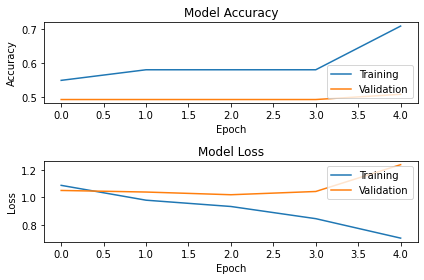

Starting price...
Epoch 1/5
8/8 - 15s - loss: 1.0843 - accuracy: 0.4039 - val_loss: 1.0395 - val_accuracy: 0.4219 - 15s/epoch - 2s/step
Epoch 2/5
8/8 - 9s - loss: 1.0477 - accuracy: 0.4902 - val_loss: 1.0324 - val_accuracy: 0.4688 - 9s/epoch - 1s/step
Epoch 3/5
8/8 - 9s - loss: 0.9273 - accuracy: 0.5686 - val_loss: 0.9310 - val_accuracy: 0.5781 - 9s/epoch - 1s/step
Epoch 4/5
8/8 - 9s - loss: 0.7254 - accuracy: 0.6824 - val_loss: 0.9881 - val_accuracy: 0.5469 - 9s/epoch - 1s/step
Epoch 5/5
8/8 - 9s - loss: 0.5046 - accuracy: 0.8980 - val_loss: 0.9391 - val_accuracy: 0.6562 - 9s/epoch - 1s/step
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


accuracy is : 
2/2 [==============================] - 0s 166ms/step - loss: 0.9391 - accuracy: 0.6562
Validation loss: 0.9391406774520874
validation accuracy: 0.65625


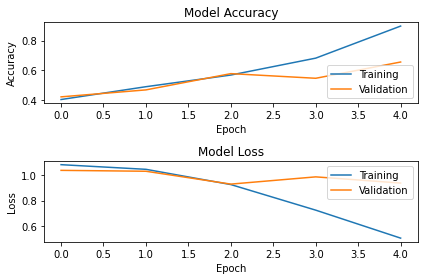

In [ ]:
tokenizing_length=training()

#Test data from xml to csv

In [ ]:
file = open("drive/MyDrive/text.xml",'r')
contents = file.read()

In [ ]:
doc = BeautifulSoup(contents,'xml')

In [ ]:
text_ = doc.find_all('text')

In [ ]:
text_list = []
for i in range(len(text_)):
   t= text_[i].get_text()
   text_list.append(t)
  
df = pd.DataFrame(list(zip(text_list)),
               columns =['text'])

In [ ]:
df.head()

,text
0,"Overall, it is a nice place and if you don't m..."
1,"We waited 15 minutes for a menu, another 20 fo..."
2,the dishes are a little too recherche and too ...
3,The pricing isn't quite clear and look out for...
4,"the menu looked great, but the food was the bi..."


In [ ]:
df.to_csv("test.csv",index=False)

In [ ]:
test_data = pd.read_csv("test.csv")
test_data.head()

,text
0,"Overall, it is a nice place and if you don't m..."
1,"We waited 15 minutes for a menu, another 20 fo..."
2,the dishes are a little too recherche and too ...
3,The pricing isn't quite clear and look out for...
4,"the menu looked great, but the food was the bi..."


#Prediction with test data



In [ ]:
def testing(tokenizing_length):
  test_data = pd.read_csv("test.csv")
  len_=test_data.shape[0] 
  lst = list(np.arange(0,len_))
  test_data['id']=lst
  

  aspects = ["food", "staff", "miscellaneous", "place","service","menu","ambience","price"]
  models_dict = {}
  predicted_df =pd.DataFrame()

  for aspect in aspects:
        aspect_df= pd.DataFrame()
        X_test = tokenizing(test_data,tokenizing_length[aspect],"testing")
        path = "/content/drive/MyDrive/NLU_lstm/"+aspect+".h5"

        model = keras.models.load_model(path)

        predictions = model.predict(X_test)

        
        predicted_polarity=[]
        aspect_score=[]
        for i in range(len(predictions)):
              max_index=np.argmax(predictions[i])
              predicted_polarity.append(max_index)
              aspect_score.append(predictions[i][max_index])
        aspect_df['id']=test_data['id']
        aspect_df['text'] = test_data['text']
        aspect_list = [aspect]*len(test_data)
        aspect_df['aspect_category']=aspect_list
        aspect_df['polarity']=predicted_polarity
        aspect_df['aspect_score'] =aspect_score
        predicted_df = predicted_df.append(aspect_df)
  return predicted_df

In [ ]:
predicted_df = testing(tokenizing_length)

In [ ]:
df=predicted_df

polarity_new=[]
for each_example in df.itertuples():
  if each_example.polarity==0:
    polarity_new.append("positive")
  elif each_example.polarity==1:
    polarity_new.append("neutral")
  else:
    polarity_new.append("negative")

df['polarity']=polarity_new
df= df.sort_values('id')
df= df[df.aspect_score>=0.7]

In [ ]:
df.to_csv("prediction.csv",index=False)

In [ ]:
dataf= pd.read_csv("prediction.csv")
test_data = pd.read_csv("test.csv")
len_=test_data.shape[0] 

#Predicted Dataframe to XML

In [ ]:
index=0
text_final ="<sentences>"
for i in range(len_):
  len_temp = dataf[dataf.id==i].shape[0]
  text = dataf[dataf.id==i].text.values[0]



  for j in range(len_temp):
    if j==0:
      text_final =text_final+"<sentence><text>"+text+"</text>"+"<aspectCategories>"
    aspect = dataf.aspect_category[index]
    polarity = dataf.polarity[index]
    text_final = text_final+ "<aspectCategory category="+'"' + aspect+ '"'+" polarity="+'"' + polarity+ '"'+"/>"
    index=index+1
  text_final = text_final+"</aspectCategories></sentence>"
text_final =text_final+"</sentences>"
print(text_final)

<sentences><sentence><text>Overall it is a nice place and if you dont mind possible attitude and the notsocheap prices it is a great place to meet for coffee or drinks they have a nice selection of that too</text><aspectCategories><aspectCategory category="food" polarity="neutral"/><aspectCategory category="menu" polarity="neutral"/><aspectCategory category="ambience" polarity="negative"/><aspectCategory category="staff" polarity="positive"/><aspectCategory category="place" polarity="neutral"/></aspectCategories></sentence><sentence><text>We waited 15 minutes for a menu another 20 for a tea another 15 for an appetizer then when the plates came out the waitress had to ask me what Id ordered</text><aspectCategories><aspectCategory category="menu" polarity="neutral"/><aspectCategory category="place" polarity="neutral"/><aspectCategory category="food" polarity="neutral"/><aspectCategory category="staff" polarity="positive"/></aspectCategories></sentence><sentence><text>the dishes are a lit